# Training a normalizing flow

In this notebook, we will train a normalizing flow network to approximate a given set of samples.

Training NF, current loss: 0.627: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:20<00:00, 14.73it/s]


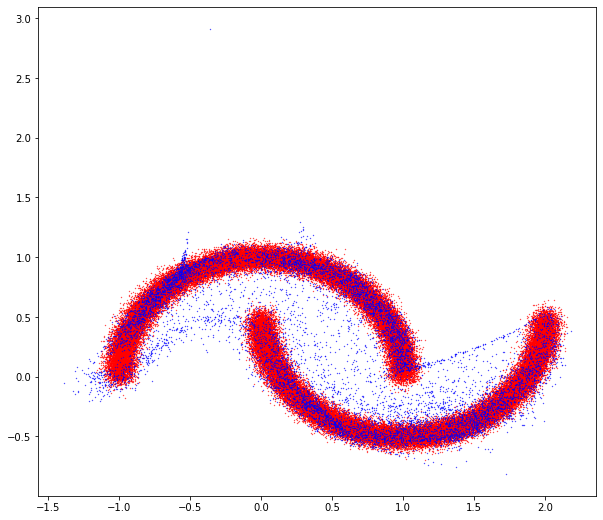

In [5]:
from flowMC.nfmodel.realNVP import RealNVP
from flowMC.nfmodel.rqSpline import RQSpline
import jax
import jax.numpy as jnp  # JAX NumPy
import jax.random as random  # JAX random
from jax.scipy.stats import multivariate_normal

from flowMC.nfmodel.utils import *
from flax import linen as nn  # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state
import optax  # Optimizers

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

"""
Training a masked RealNVP flow to fit the dual moons dataset.
"""

num_epochs = 300
batch_size = 10000
learning_rate = 0.001
momentum = 0.9
n_layers = 10
n_hidden = 100
dt = 1 / n_layers

data = make_moons(n_samples=100000, noise=0.05)

key1, rng, init_rng = jax.random.split(jax.random.PRNGKey(0), 3)
model = RealNVP(10, 2, n_hidden, 1)

def create_train_state(rng, learning_rate, momentum):
    params = model.init(rng, jnp.ones((1, 2)))["params"]
    tx = optax.adam(learning_rate, momentum)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

state = create_train_state(init_rng, learning_rate, momentum)

variables = model.init(rng, jnp.ones((1, 2)))["variables"]


data = jnp.array(data[0])


train_flow, train_epoch, train_step = make_training_loop(model)
rng, state, loss_values = train_flow(
    rng, state, variables, data, num_epochs, batch_size
)


rng_key_nf = jax.random.PRNGKey(124098)
nf_samples = sample_nf(model, state.params, rng_key_nf, 10000, variables)
plt.figure(figsize=(10, 9))
plt.scatter(data[:, 0], data[:, 1], s=0.1, c="r", label="Data")
plt.scatter(nf_samples[1][0][:, 0], nf_samples[1][0][:, 1], s=0.1, c="b", label="NF")
plt.show()


Training NF, current loss: 0.400: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:37<00:00,  8.07it/s]


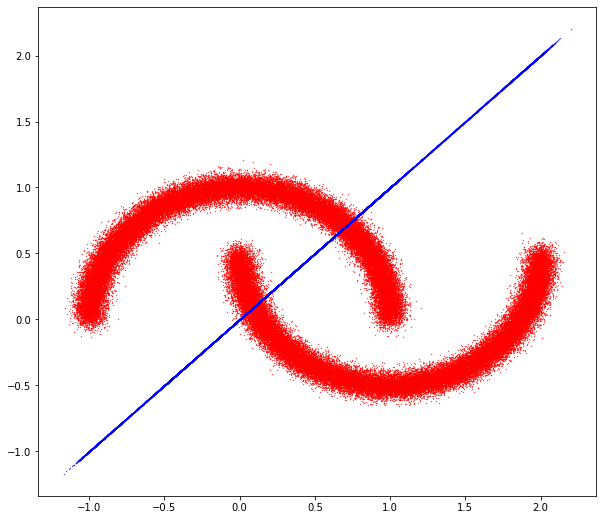

In [14]:
data = make_moons(n_samples=100000, noise=0.05)[0]
data = jnp.array(data)
key1, rng, init_rng = jax.random.split(jax.random.PRNGKey(0), 3)
model = RQSpline(2, 10, [128, 128], 8)

def create_train_state(rng, learning_rate, momentum):
    params = model.init(rng, jnp.ones((1, 2)))["params"]
    tx = optax.adam(learning_rate, momentum)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

state = create_train_state(init_rng, learning_rate, momentum)

variables = model.init(rng, jnp.ones((1, 2)))["variables"]

train_flow, train_epoch, train_step = make_training_loop(model)
rng, state, loss_values = train_flow(
    rng, state, variables, data, num_epochs, batch_size
)


rng_key_nf = jax.random.PRNGKey(124098)
nf_samples = sample_nf(model, state.params, rng_key_nf, 10000, variables)
plt.figure(figsize=(10, 9))
plt.scatter(data[:, 0], data[:, 1], s=0.1, c="r", label="Data")
plt.scatter(nf_samples[1], nf_samples[1], s=0.1, c="b", label="NF")
plt.show()


In [13]:
nf_samples[1]

DeviceArray([[ 0.10147899,  0.0317862 ],
             [ 1.8065097 , -0.12207556],
             [-0.3164193 ,  1.0137448 ],
             ...,
             [ 1.3219459 , -0.50998104],
             [ 0.58796585, -0.45092726],
             [ 0.850981  ,  0.50673836]], dtype=float32)